#### Importing main libraries

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import copy

/Users/leilasapple/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/Users/leilasapple/.matplotlib/matplotlibrc", line #621
  (fname, cnt))


#### Path directory 

In [2]:
input_data_path='/Users/leilasapple/Documents/Springboard/recruit-restaurant-visitor-forecasting/input_files/'
output_data_path='/Users/leilasapple/Documents/Springboard/recruit-restaurant-visitor-forecasting/output_files/'

Data file which is generated by other part of project

In [3]:
data=pd.read_csv(os.path.join(output_data_path,'data1.csv'))

### Building the model

To check the relevance of the features to the number of visitors: ckeck the regression coefficent 
5 first features are categorical. Therefore we ignore them. 

In [4]:
coff=[0.,0.,0.,0.]
for i ,item in enumerate(data.keys()):
    if i>4:
        if np.corrcoef(data.iloc[:,i], data['visitor'])[0, 1]>0.2:
            print(i,item,'\t',np.corrcoef(data.iloc[:,i], data['visitor'])[0, 1])


6 dt 	 0.2658337047572721
11 genre_area_index 	 0.24785015458927526
13 store_holiday_index 	 0.3549122559563655
15 store_month_index 	 0.47783929358821536
17 day_month_index 	 0.21999743031956168
18 holiday_day_month_index 	 0.23026220728665345
20 store_index 	 0.34467732747713836
21 store_day_index 	 0.4431081932798821


##### Extracting X and Y variable from data

In [5]:
modelinput=data.loc[:,[ 'dt', 'area_index', 'genre_index', 'genre_area_index','holiday_index', 'store_holiday_index',
                       'month_index', 'store_month_index','day_month_index','store_index','holiday_day_month_index',
                       'day_index','store_day_index']]

In [6]:
X=modelinput.values.copy()
y_org=copy.deepcopy(data.loc[:,['visitor','store_index']].values)

##### Encoding categorical variables
using the average value of customers for area,genre, holiday, day and month results better accuracy, rather that encoding those data.

In [7]:
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#labelencoder_X = LabelEncoder()
#X[:,0] = labelencoder_X.fit_transform(X[:, 0])
#X[:,1] = labelencoder_X.fit_transform(X[:, 1])
#X[:,2] = labelencoder_X.fit_transform(X[:, 2])
#X[:,3] = labelencoder_X.fit_transform(X[:, 3])
#X[:,4] = labelencoder_X.fit_transform(X[:, 4])

#onehotencoder = OneHotEncoder(categorical_features = [0,1,2,3,4])
#X = onehotencoder.fit_transform(X).toarray().astype(float)

In [8]:
len(X[0,:])

13

##### Categorizing independent variables
for each restaurant, the number of visitors catogorized if they are below the average or above the average.

In [9]:
y=np.zeros(len(y_org),int)

for i ,item in enumerate(y_org[:,0]):
    if item <np.around(y_org[i,1]): y[i]=1
    if item >=np.around(y_org[i,1]): y[i]=2


##### Checking for imbalanced data

In [10]:

balanced_ratio1=len(y[y==1])*100/len(y)
balanced_ratio2=len(y[y==2])*100/len(y)

print('Balanced ratios',balanced_ratio1,balanced_ratio2)

Balanced ratios 63.48338398896518 36.51661601103482


##### Spliting the data to test and training data

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
y_train=y_train.astype(int)
y_test=y_test.astype(int)

##### The model

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 50, random_state = 0,bootstrap=True,n_jobs=-1)
#,min_samples_leaf=5,min_samples_split=5,max_depth=None)

model.fit(x_train, y_train)

print(model.get_params().keys())
print(model.get_params())
print('SCORE: ',model.score(x_train,y_train))


dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
SCORE:  0.9989409638362962


##### Applying the model over test dataset

In [13]:
y_pred = model.predict(x_test)
y_pred=np.around(y_pred).astype(int)

##### Evaluation the model

In [14]:
from sklearn import metrics

print("Precision: ",metrics.precision_score(y_test, y_pred,average='micro'))
print("Recall: ",metrics.recall_score(y_test, y_pred,average='micro'))
print('accuracy: ',metrics.accuracy_score(y_test, y_pred))
f= open(os.path.join(output_data_path,'output_RFC.txt'),"a")
f.write(str(datetime.now())+ '\n')
f.write(str(modelinput.keys())+ '\n')
f.write("Model : "+str(model)+ '\n')
f.write("SCORE : "+str(model.score(x_train,y_train)) + '\n')
f.write("Accuracy : "+str(metrics.accuracy_score(y_test, y_pred)) + '\n')
f.write('Precision: '+str(metrics.precision_score(y_test, y_pred,average='micro'))+ '\n')
f.write('Recall: '+str(metrics.recall_score(y_test,y_pred,average='micro'))+ '\n')

f.close()

Precision:  0.6817810735424179
Recall:  0.6817810735424179
accuracy:  0.6817810735424179


##### Confusion matrix evaluation

In [15]:
from sklearn.metrics import confusion_matrix

CONFM = confusion_matrix(y_test, y_pred)
tn = CONFM[0,0]; fp = CONFM[0,1]; fn = CONFM[1,0]; tp = CONFM[1,1];

NP = fn+tp # Num positive examples
NN = tn+fp # Num negative examples
N  = NP+NN
CONFM_accuracy=(tp+tn)/N
CONFM_sensitivity = tp / (tp + fn) 
CONFM_specificity = tn / (fp + tn) 
print('accuracy from confusion matrix',CONFM_accuracy)
print('sensitivity from confusion matrix',CONFM_sensitivity)
print('specificity from confusion matrix',CONFM_specificity)


accuracy from confusion matrix 0.6817810735424179
sensitivity from confusion matrix 0.4461666821173635
specificity from confusion matrix 0.8183439901133738


Visulazing the confusion matrix

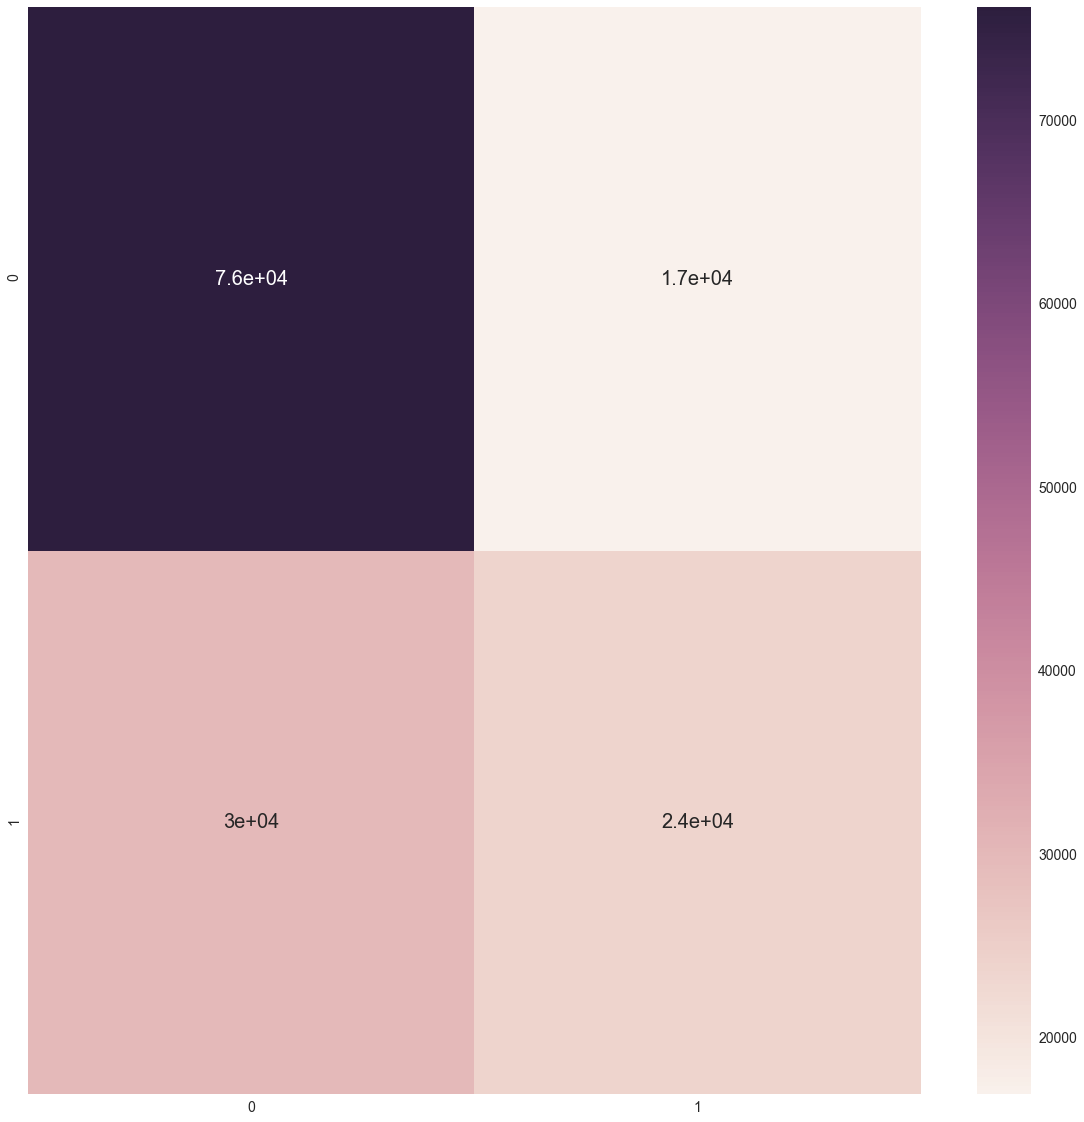

In [18]:
import matplotlib.pyplot as plt
import seaborn as sn
fig=plt.figure(figsize=(20, 20))

sn.set(font_scale=1.4)#for label size
sn.heatmap(CONFM, annot=True,annot_kws={"size": 20})# font size
plt.show()
fig.savefig(os.path.join(output_data_path,'Confusion_Matrix_.png'))   # save the figure to file\n",
plt.close(fig)


##### Choosing hyperparameters

In [ ]:
from sklearn.grid_search import GridSearchCV
datetime.now().time()
param_grid = {#"n_estimators": [10,50,100],
    "max_depth": [None,2,4,6],
#    "criterion" : ["gini", "entropy"],
#    "max_features": np.arange(5,55,250),
    "min_samples_split": [2,4,6],
    "min_samples_leaf": [1,2,4,6],
    "max_leaf_nodes"=[None,2,3,4,5],
    "n_jobs"=[-1,1]}
gridsearch=GridSearchCV(model, param_grid, scoring='accuracy',cv=10)
gridsearch=gridsearch.fit(x_train,y_train)

datetime.now().time()
print(gridsearch.best_params_)
print(gridsearch.best_score_)

f= open(os.path.join(output_data_path,'output_RFC.txt'),"a")
f.write(str(datetime.now().time())+ '\n')
f.write("GridSearch : "+str(gridsearch)+ '\n')
f.write("SCORE : "+str(gridsearch.best_score_) + '\n')

f.close()



In [37]:
y_pred[y_pred==1].sum()


117535

#### Visulazation the results

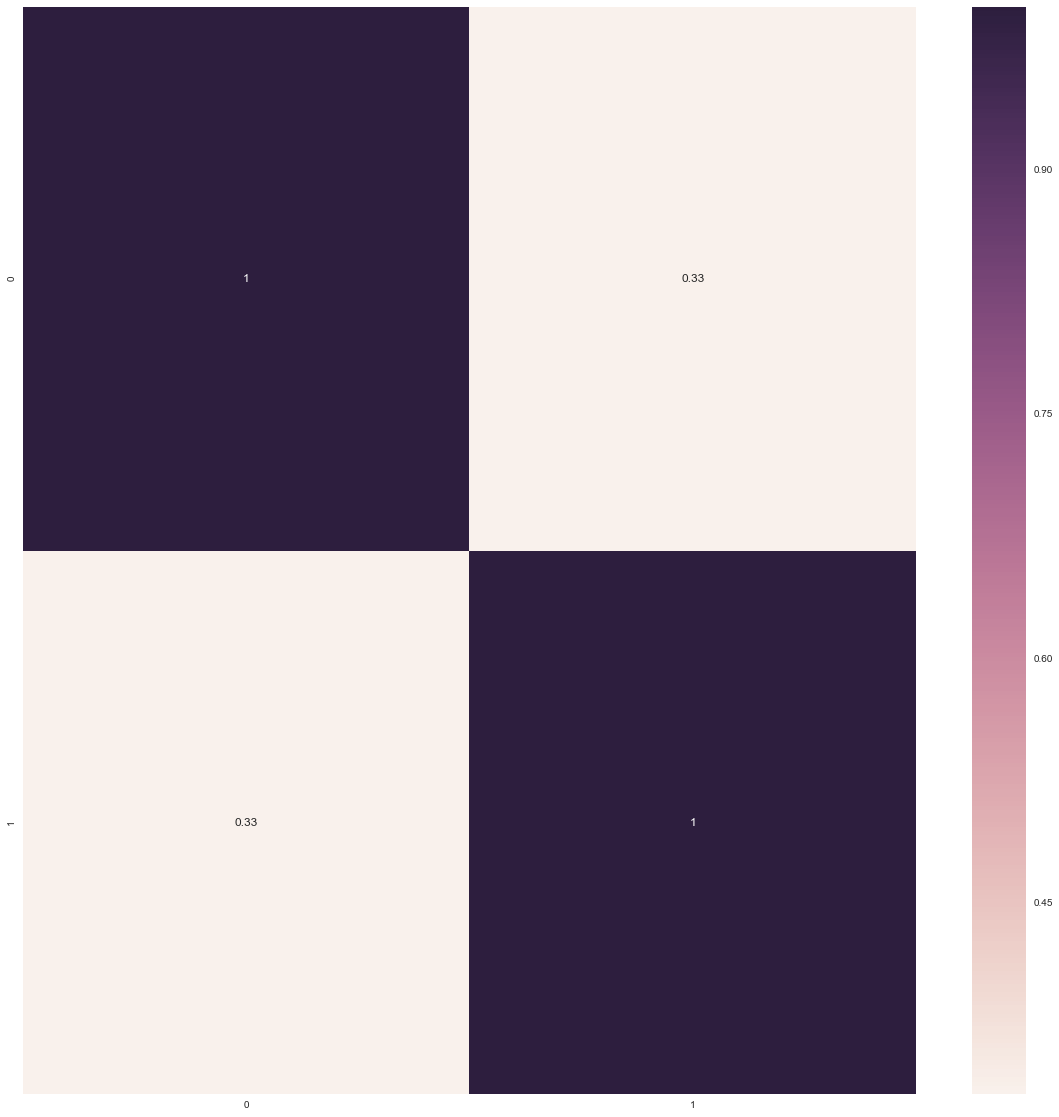

In [42]:
import matplotlib.pyplot as plt
import seaborn as sn
fig=plt.figure(figsize=(20, 20))
sn.heatmap(np.corrcoef(y_test, y_pred), annot=True)

plt.show()
fig.savefig(os.path.join(output_data_path,'Forcast.png'))   # save the figure to file\n",
plt.close(fig) 

In [38]:
np.corrcoef(y_test, y_pred)

array([[1.        , 0.33184501],
       [0.33184501, 1.        ]])